In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from functools import partial

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score,roc_auc_score,roc_curve
from sklearn.metrics import classification_report

import xgboost as xgb
import lightgbm as lgb
import gc


from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [3]:
model_data = pd.read_csv("/content/drive/MyDrive/colab_data/chicago_food_inspection/model_data_final.csv")

model_data["datetime"] = pd.to_datetime(model_data["inspection_date"])
model_data.sort_values("datetime", inplace=True)
df=model_data.copy()

df = df.drop(['license','facility_type', 'inspection_date', 'datetime'], axis = 1)
df.dropna(inplace=True)

dfIndexLabel = pd.DataFrame({
    "inspection_id": df.inspection_id,
    "label": df.label,
})
df=df.set_index('inspection_id')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='label'), df['label'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

In [12]:
sm = SMOTE(random_state = 42, k_neighbors=11)
X_train_oversampled_s, y_train_oversampled_s = sm.fit_sample(X_train_scaled, y_train)

pd.Series(y_train_oversampled_s).value_counts().sort_index()

0    28687
1    28687
2    28687
dtype: int64

RELU

In [22]:
y_train_tf = pd.get_dummies(y_train_oversampled_s)
y_val_tf = pd.get_dummies(y_val)
y_test_tf = pd.get_dummies(y_test)

In [54]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[107]),
    layers.Dense(512, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    layers.Dense(256, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    layers.Dense(3, activation='sigmoid'),
])

In [55]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [56]:
history = model.fit(
    X_train_oversampled_s, y_train_tf,
    validation_data=(X_val_scaled, y_val_tf),
    batch_size=1000,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1
)



Epoch 1/1000
87/87 [==============================] - 5s 50ms/step - loss: 1.1261 - accuracy: 0.5747 - val_loss: 1.0550 - val_accuracy: 0.2691
Epoch 2/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.7251 - accuracy: 0.6854 - val_loss: 1.3016 - val_accuracy: 0.2025
Epoch 3/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.6551 - accuracy: 0.7122 - val_loss: 1.3800 - val_accuracy: 0.2280
Epoch 4/1000
87/87 [==============================] - 4s 48ms/step - loss: 0.6191 - accuracy: 0.7313 - val_loss: 1.2828 - val_accuracy: 0.3329
Epoch 5/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.6004 - accuracy: 0.7414 - val_loss: 1.0965 - val_accuracy: 0.4382
Epoch 6/1000
87/87 [==============================] - 4s 48ms/step - loss: 0.5723 - accuracy: 0.7550 - val_loss: 0.9044 - val_accuracy: 0.5486
Epoch 7/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.5535 - accuracy: 0.7625 - val_loss: 0.8510 - val_accuracy: 0.5657

Accuracy is of NeuralNetworks 73.72142739680973
Precision of NeuralNetworks 75.55968077574875
Recall of NeuralNetworks 73.72142739680973
F1 score of NeuralNetworks 74.51387534117507
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      9512
           1       0.37      0.39      0.38      2222
           2       0.32      0.52      0.39       428

    accuracy                           0.74     12162
   macro avg       0.52      0.58      0.54     12162
weighted avg       0.76      0.74      0.75     12162



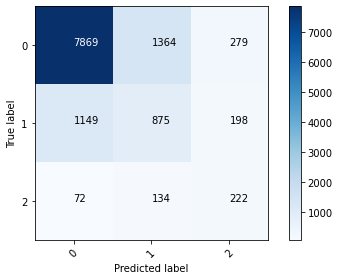

In [59]:
yhat1_nn = model.predict_classes(X_test_scaled)

accuracy = accuracy_score(y_test, yhat1_nn)*100
print("Accuracy is of NeuralNetworks", accuracy)

precision = precision_score(y_test, yhat1_nn, average='weighted')*100
print("Precision of NeuralNetworks", precision)

recall = recall_score(y_test, yhat1_nn,average='weighted')*100
print("Recall of NeuralNetworks", recall)

f1 = f1_score(y_test, yhat1_nn,average='weighted')*100
print("F1 score of NeuralNetworks", f1)

labels = [0,1,2] 
print(classification_report(y_test, yhat1_nn, labels)) 
cnf_matrix = confusion_matrix(y_test, yhat1_nn, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 
threshold = cnf_matrix.max() / 2 
for i in range(cnf_matrix.shape[0]): 
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) 
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

Best Validation Loss: 0.6224
Best Validation Accuracy: 0.7564


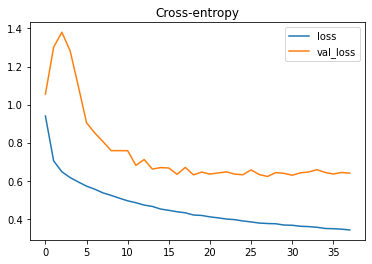

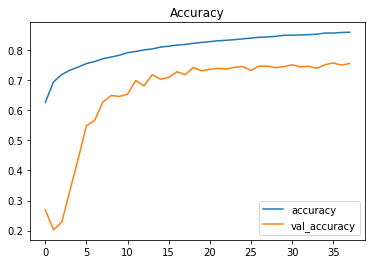

In [58]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))